In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)

def create_cnn_model(dropout_rate, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add the dense layers (top layers)
    x = base_model.output
    x = Flatten()(x)  # Flatten the output layer to 1 dimension
    x = Dense(512, activation='relu')(x)   #  First dense layer
    x = Dropout(dropout_rate)(x)  # Dropout to reduce overfitting
    predictions = Dense(len(categories), activation='softmax')(x)  # Output layer

    # Final model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

print("Images loaded successfully")


Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categor

Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 1.1978 - accuracy: 0.5927 - val_loss: 0.5139 - val_accuracy: 0.8294
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.5832 - accuracy: 0.7978 - val_loss: 0.4769 - val_accuracy: 0.8403
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.4738 - accuracy: 0.8381 - val_loss: 0.3965 - val_accuracy: 0.8641
Epoch 4/20
375/375 [==============================] - 2s 7ms/step - loss: 0.4106 - accuracy: 0.8546 - val_loss: 0.4065 - val_accuracy: 0.8584
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.3795 - accuracy: 0.8657 - val_loss: 0.3259 - val_accuracy: 0.8863
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.3304 - accuracy: 0.8859 - val_loss: 0.3574 - val_accuracy: 0.8803
Epoch 7/20
375/375 [==============================] - 2s 7ms/step - loss: 0.3283 - accuracy: 0

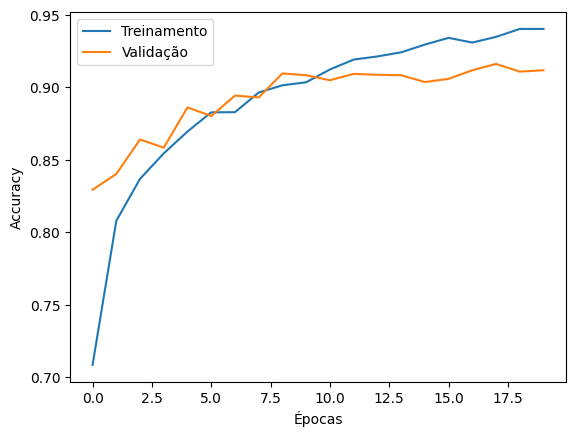

In [6]:
best_learning_rate = 0.001
dropout_rate = 0.5

print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(dropout_rate, best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_pso_train_accuracy = best_model_history.history['accuracy'][-1]
best_pso_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treinamento (CNN VGG-16):", best_pso_train_accuracy)
print("Melhor Accuracy de Validação (CNN VGG-16):", best_pso_validation_accuracy)

import matplotlib.pyplot as plt

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.9049999713897705, Loss: 0.2878306210041046
